# DAWN JWST Archive (DJA) Tutorial: UDS PRIMER Field Analysis

This notebook demonstrates the tools available through the DAWN JWST Archive (DJA) for analyzing imaging and spectroscopic data over extragalactic fields, using the **PRIMER UDS North** pointing as an example.

## What You'll Learn:
1. **Access DJA photometric catalogs** - Multi-band JWST photometry from Grizli reductions
2. **Cross-match with spectroscopic data** - Link to MSAExp NIRSpec observations on AWS
3. **Create image cutouts** - Use the Grizli cutout server for on-demand visualizations
4. **Analyze photometric redshifts** - Work with EAzY template fitting results
5. **Display matched spectra** - View spectroscopic observations for catalog sources

## Required Package Installation

```bash
# Core scientific packages
pip install numpy pandas matplotlib astropy

# Specialized astronomy packages
pip install eazy-py grizli

# Image processing
pip install pillow

# For Jupyter notebooks
pip install ipython
```

## Data Sources
- **DJA/Grizli**: JWST imaging mosaics and photometric catalogs
- **EAzY**: Photometric redshift fitting results 
- **MSAExp**: Public NIRSpec spectroscopic survey data hosted on AWS
- **Grizli Cutout Server**: Web service for creating JWST image cutouts

In [1]:
# Standard library imports
from io import BytesIO

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from PIL import Image

# Astropy imports
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

# EAzY imports - for reading photometric redshift catalogs
from eazy import hdf5

# IPython/Jupyter imports - for rich display in notebooks
from IPython.display import display, Markdown

Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git


# Step 1: Load DJA Photometric Catalog

Load the PRIMER UDS North photometric catalog from the DJA/Grizli database. This catalog contains:
- Multi-band JWST photometry (NIRCam filters)
- Source positions (RA, Dec)
- Photometric measurements and uncertainties

In [2]:
import os
import grizli
import grizli.catalog
from grizli import utils

# DJA/Grizli data location on AWS
field = 'primer-uds-north-grizli-v7.0'
url_path = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7'

# Load the photometric catalog directly from AWS
print(f"Loading photometric catalog for {field}...")
uds_phot_cat = utils.read_catalog(f'{url_path}/{field}_phot.fits')

print(f"Loaded {len(uds_phot_cat)} sources")
print(f"Available columns: {uds_phot_cat.colnames[:10]}...")  # Show first 10 columns

Loading photometric catalog for primer-uds-north-grizli-v7.0...
Loaded 73227 sources
Available columns: ['id', 'thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y']...


In [3]:
# Convert to pandas DataFrame for easier manipulation
df_phot = uds_phot_cat.to_pandas()
df_phot.set_index('id', inplace=True)

print(f"Photometric catalog shape: {df_phot.shape}")
print("\nFirst few sources:")
display(df_phot[['ra', 'dec', 'mag_auto', 'flux_radius']].head())

Photometric catalog shape: (73227, 516)

First few sources:


,ra,dec,mag_auto,flux_radius
id,,,,
1,34.535419,-5.212179,NaN,0.000000
2,34.528194,-5.212183,NaN,0.000000
3,34.525208,-5.212181,NaN,0.000000
4,34.521265,-5.212182,NaN,0.000000
5,34.512019,-5.212185,26.118439,708.810055


# Step 2: Load MSAExp Spectroscopic Catalog

MSAExp is a public database of NIRSpec spectroscopic observations hosted on AWS. This section:
1. Downloads the emission line catalog with spectroscopic redshifts
2. Sets up metadata (column descriptions and units)
3. Creates URLs for on-demand visualizations (cutouts, slit positions, spectra)
4. Prepares the data for cross-matching with photometric sources

In [4]:
# Load MSAExp spectroscopic database from AWS S3
# MSAExp contains NIRSpec observations with emission line measurements and spectroscopic redshifts

from grizli import utils
from astropy.utils.data import download_file

# Download the main emission line catalog (cached locally after first download)
table_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.csv.gz"
tab = utils.read_catalog(download_file(table_url, cache=True), format='csv')

# Download column descriptions to understand the data structure
columns_url = "https://s3.amazonaws.com/msaexp-nirspec/extractions/dja_msaexp_emission_lines_v4.0.columns.csv"
tab_columns = utils.read_catalog(download_file(columns_url, cache=True), format='csv')

# Set column metadata (units, formats, descriptions) for better data handling
for row in tab_columns:
    c = row['column']
    if row['unit'] != '--':
        tab[c].unit = row['unit']
    if row['format'] != '--':
        tab[c].format = row['format']
    if row['description'] != '--':
        tab[c].description = row['description']

# Set up URL templates for generating visualizations on-demand
# RGB cutout URL - creates 3-color images using F115W, F277W, F444W filters
RGB_URL = "https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={ra}%2C{dec}"

# Extract metafile identifier for NIRSpec slit overlays
tab['metafile'] = [m.split('_')[0] for m in tab['msamet']]

# Slit overlay URL - shows NIRSpec slit positions on sky images
SLIT_URL = "https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={ra}%2C{dec}&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile={metafile}"

# Spectrum file URL - links to processed spectrum files on AWS
FITS_URL = "https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{file}"

# Create HTML image tags for displaying cutouts and spectra in notebooks
tab['Thumb'] = [
    "<img src=\"{0}\" height=200px>".format(
        RGB_URL.format(**row['ra','dec'])
    )
    for row in tab
]

tab['Slit_Thumb'] = [
    "<img src=\"{0}\" height=200px>".format(
        SLIT_URL.format(**row['ra','dec','metafile'])
    )
    for row in tab
]

# Links to spectrum plots in different units
tab['Spectrum_fnu'] = [
    "<img src=\"{0}\" height=200px>".format(
        FITS_URL.format(**row['root','file']).replace('.spec.fits', '.fnu.png')
    )
    for row in tab
]

tab['Spectrum_flam'] = [
    "<img src=\"{0}\" height=200px>".format(
        FITS_URL.format(**row['root','file']).replace('.spec.fits', '.flam.png')
    )
    for row in tab
]

print(f"Loaded {len(tab)} spectroscopic sources from MSAExp catalog")


Loaded 52181 spectroscopic sources from MSAExp catalog


In [5]:
# Step 3: Cross-match Photometric and Spectroscopic Catalogs

# Create coordinate objects for spatial matching
photo_coords = SkyCoord(ra=df_phot['ra'].values*u.degree, dec=df_phot['dec'].values*u.degree)
spec_coords = SkyCoord(ra=tab['ra'], dec=tab['dec'])

# Find nearest spectroscopic neighbor for each photometric source
idx, d2d, d3d = photo_coords.match_to_catalog_sky(spec_coords)

# Set matching radius - sources must be within 0.5 arcseconds
max_sep = 0.5 * u.arcsec
match_mask = d2d < max_sep

num_matches = match_mask.sum()
print(f"Found {num_matches} photometric sources with spectroscopic matches within {max_sep.value}\"")

# Create matched catalog combining photometry + spectroscopy
if num_matches > 0:
    df_matched = df_phot[match_mask].copy()
    matched_spec_indices = idx[match_mask]
    
    # Add spectroscopic information
    df_matched['spec_sep_arcsec'] = d2d[match_mask].to(u.arcsec).value
    df_matched['spec_z'] = tab['z_best'][matched_spec_indices]
    df_matched['spec_ra'] = tab['ra'][matched_spec_indices]
    df_matched['spec_dec'] = tab['dec'][matched_spec_indices]
    df_matched['spec_file'] = tab['file'][matched_spec_indices]
    
    print(f"\nMatched catalog created with {len(df_matched)} sources")
    print("\nExample matched sources:")
    display(df_matched[['ra', 'dec', 'spec_z', 'spec_sep_arcsec']].head())
else:
    print("No matches found within search radius")
    df_matched = None

Found 3003 photometric sources with spectroscopic matches within 0.5"

Matched catalog created with 3003 sources

Example matched sources:


,ra,dec,spec_z,spec_sep_arcsec
id,,,,
7,34.309048,-5.212198,-1.000000,0.029583
70,34.438457,-5.212114,2.720521,0.110373
110,34.465770,-5.211988,6.091966,0.074235
129,34.262955,-5.212001,5.675725,0.195730
146,34.441936,-5.211958,1.480750,0.102140


# Step 4: Create Image Cutouts Using Grizli Cutout Server

The `quick_cutout()` function uses the Grizli cutout server to create on-demand multi-band JWST image cutouts. This helps visualize galaxy morphology and verify source identifications.

In [6]:
def quick_cutout(galaxy, sy=2, pl=2, size=1.5, scl=3, 
                 filters="f090w-clear,f115w-clear,f150w-clear,f200w-clear,f277w-clear,f356w-clear,f444w-clear"):
    """
    Create a multi-band JWST image cutout using the Grizli cutout server
    
    Parameters:
    -----------
    galaxy : pandas.Series
        Galaxy data row containing 'ra' and 'dec' columns
    sy : float
        Figure size scaling factor (default: 2)
    pl : int
        Pixel smoothing parameter - higher = smoother (default: 2)
    size : float
        Cutout size in arcminutes (default: 1.5)
    scl : float
        Image scaling factor - higher = more stretched (default: 3)
    filters : str
        Comma-separated list of JWST filters for the cutout
        
    Returns:
    --------
    galaxy_id : int or str
        Galaxy identifier from the index
    fig : matplotlib.figure.Figure
        Figure object containing the cutout
    img : PIL.Image
        Image object from the server
    """
    from PIL import Image
    import requests
    from io import BytesIO
    
    # Get coordinates
    ra = f"{galaxy.ra:.6f}"
    dec = f"{galaxy.dec:.6f}"
    rd = f"{ra},{dec}"
    
    # Print useful links
    print(f"Grizli Cluster Map: https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/uds/index.html?coords={rd}&zoom=8")
    
    # Construct cutout server URL
    url = f"https://grizli-cutout.herokuapp.com/thumb?coord={rd}&all_filters=True&size={size}&scl={scl}&asinh=True&filters={filters}&rgb_scl=1.0,0.95,1.2&pl={pl}"
    print(f"Cutout URL: {url}")
    
    # Download and process image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    
    # Create matplotlib figure
    fig, ax = plt.subplots(1, 1, figsize=(sy*4, sy+0.2))
    data = np.array(img)
    
    # Clean up no-data regions (make black pixels white)
    black = data.max(axis=2) == 0
    for ioff in range(-2, 3):
        black &= np.roll(black, ioff, axis=0)
    for i in range(3):
        data[:,:,i][black] = 255
    
    # Display
    ax.imshow(data, interpolation='nearest', origin='upper')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    fig.tight_layout(pad=0.2)
    
    return galaxy.name, fig, img

# Step 5: Example Analysis - Visualize a Galaxy with Spectroscopy

Select a galaxy from the matched catalog (photometry + spectroscopy) and create an image cutout.

Analyzing galaxy 70:
  Position: RA=34.438457, Dec=-5.212114
  Spectroscopic redshift: z=2.7205
  Match separation: 0.110 arcsec
Grizli Cluster Map: https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/uds/index.html?coords=34.438457,-5.212114&zoom=8
Cutout URL: https://grizli-cutout.herokuapp.com/thumb?coord=34.438457,-5.212114&all_filters=True&size=1.5&scl=3&asinh=True&filters=f090w-clear,f115w-clear,f150w-clear,f200w-clear,f277w-clear,f356w-clear,f444w-clear&rgb_scl=1.0,0.95,1.2&pl=2


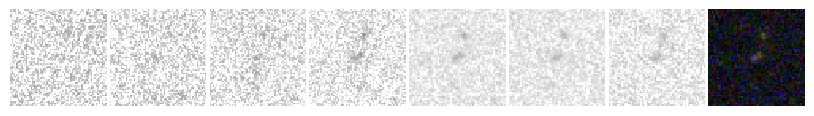

In [7]:
# Select a galaxy from the matched catalog
# Change this ID to explore different sources
example_gal_id = 70

if df_matched is not None and example_gal_id in df_matched.index:
    galaxy = df_matched.loc[example_gal_id]
    
    print(f"Analyzing galaxy {example_gal_id}:")
    print(f"  Position: RA={galaxy.ra:.6f}, Dec={galaxy.dec:.6f}")
    print(f"  Spectroscopic redshift: z={galaxy.spec_z:.4f}")
    print(f"  Match separation: {galaxy.spec_sep_arcsec:.3f} arcsec")
    
    # Create and display image cutout
    gal_id, fig, img = quick_cutout(galaxy)
    plt.show()
else:
    print(f"Galaxy {example_gal_id} not found in matched catalog")

# Step 6: Load EAzY Photometric Redshift Fits (Optional)

This section loads the EAzY template fitting results to visualize the SED (Spectral Energy Distribution) fits. You'll need the EAzY HDF5 files and photometry files for this to work.

In [8]:
import eazy.hdf5

# Create symlinks to EAzY template files if not present
if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

# Define the EAzY file root (updated version)
eazy_field = field.replace('7.0', '7.2')
root = f'{eazy_field}-fix'

# Download EAzY photometric redshift files if not present
if not os.path.exists(f'{root}.eazypy.h5'):
    print(f"Downloading EAzY photoz files...")
    os.system(f'wget {url_path}/{eazy_field}-fix.photoz.tar.gz')
    os.system(f'tar xzvf {eazy_field}-fix.photoz.tar.gz')
else:
    print("EAzY files already present")

# Initialize EAzY photoz object from HDF5 file
print(f"Loading EAzY photometric redshift fits from {root}.eazypy.h5...")
self = eazy.hdf5.initialize_from_hdf5(h5file=root+'.eazypy.h5')

# Fit stellar templates (optional, improves fits for some sources)
self.fit_phoenix_stars()

# Load the photometric redshift output catalog
zout = utils.read_catalog(root+'.eazypy.zout.fits')
self.cat = utils.read_catalog(root+'_phot_apcorr.fits')
cat = self.cat

print(f"EAzY catalog loaded with {len(cat)} sources")

EAzY files already present
Loading EAzY photometric redshift fits from primer-uds-north-grizli-v7.2-fix.eazypy.h5...
set param: APPLY_IGM y
set param: APPLY_PRIOR y
set param: ARRAY_NBITS 32.0
set param: BINARY_OUTPUT y
set param: CACHE_FILE photz.tempfilt
set param: CATALOG_FILE primer-uds-north-grizli-v7.2-fix_phot_apcorr.fits
set param: CATALOG_FORMAT ascii.commented_header
set param: CAT_HAS_EXTCORR False
set param: CHI2_SCALE 1.0
set param: DUMP_TEMPLATE_CACHE n
set param: FILTERS_RES FILTER.RES.latest
set param: FILTER_FORMAT 1.0
set param: FIX_ZSPEC n
set param: GET_ZP_OFFSETS n
set param: H0 70.0
set param: IGM_SCALE_TAU 1.0
set param: MAGNITUDES n
set param: MAIN_OUTPUT_FILE primer-uds-north-grizli-v7.2-fix.eazypy
set param: MW_EBV 0.0199
set param: NMF_TOLERANCE 0.0001
set param: NOT_OBS_THRESHOLD -90.0
set param: N_MIN_COLORS 5.0
set param: OBS_SED_FILE n
set param: OMEGA_L 0.7
set param: OMEGA_M 0.3
set param: OUTPUT_DIRECTORY OUTPUT
set param: POFZ_FILE n
set param: PRINT_

/Users/wnanayakkara/opt/anaconda3/envs/grizli_jwst/lib/python3.11/site-packages/eazy/photoz.py:1330: RuntimeWarning: invalid value encountered in log10
  self.prior_mag_cat += -2.5*np.log10(np.squeeze(self.fnu[:,ix]))


Read PRIOR_FILE:  templates/prior_F160W_TAO.dat
Template grid: templates/sfhz/agn_blue_sfhz_13.param (this may take some time)
TemplateGrid: user-provided tempfilt_data
Process templates: 0.401 s


294it [00:12, 23.67it/s]


h5: read corr_sfhz_13_bin0_av0.01.fits
h5: read corr_sfhz_13_bin0_av0.25.fits
h5: read corr_sfhz_13_bin0_av0.50.fits
h5: read corr_sfhz_13_bin0_av1.00.fits
h5: read corr_sfhz_13_bin1_av0.01.fits
h5: read corr_sfhz_13_bin1_av0.25.fits
h5: read corr_sfhz_13_bin1_av0.50.fits
h5: read corr_sfhz_13_bin1_av1.00.fits
h5: read corr_sfhz_13_bin2_av0.01.fits
h5: read corr_sfhz_13_bin2_av0.50.fits
h5: read corr_sfhz_13_bin2_av1.00.fits
h5: read corr_sfhz_13_bin3_av0.01.fits
h5: read corr_sfhz_13_bin3_av0.50.fits
h5: read fsps_4590.fits
h5: read j0647agn+torus.fits
Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
Failed to `import dust_attenuation`
Install from t

/Users/wnanayakkara/opt/anaconda3/envs/grizli_jwst/lib/python3.11/site-packages/eazy/photoz.py:5562: RuntimeWarning: invalid value encountered in divide
  star_tnorm = _num/_den
/Users/wnanayakkara/opt/anaconda3/envs/grizli_jwst/lib/python3.11/site-packages/eazy/photoz.py:5582: RuntimeWarning: invalid value encountered in divide
  star_min_chinu = star_min_chi2 / (self.nusefilt - 1)


EAzY catalog loaded with 88044 sources


Plotting EAzY SED fit for galaxy 70


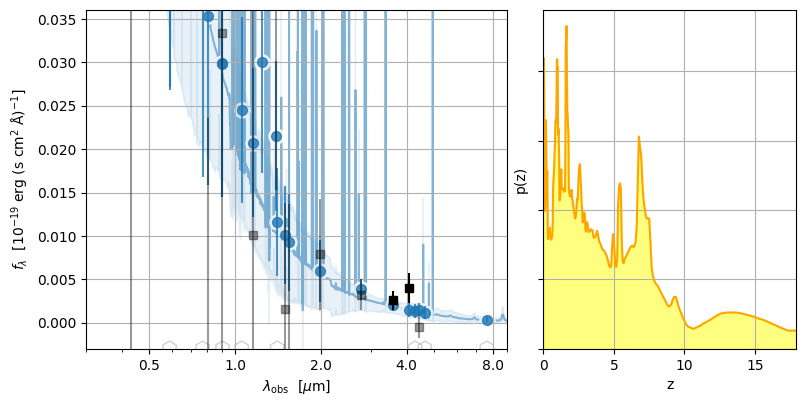

In [9]:
# Plot the EAzY SED fit for the example galaxy
# This shows the template fit to the multi-band photometry

if 'self' in dir() and example_gal_id in cat['id']:
    print(f"Plotting EAzY SED fit for galaxy {example_gal_id}")
    sed_fig, sed_data = self.show_fit(id=example_gal_id, add_label=False)
    plt.show()
else:
    print(f"EAzY data not loaded or galaxy {example_gal_id} not in EAzY catalog")

# Step 7: Display NIRSpec Spectrum

If the selected galaxy has spectroscopic observations in MSAExp, display the 1D extracted spectrum.

Galaxy 70 spectroscopic data:
  Spectroscopic redshift: z = 2.7205
  Spectrum URL: https://s3.amazonaws.com/msaexp-nirspec/extractions/capers-udsp5-v4/capers-udsp5-v4_prism-clear_6368_96539.flam.png


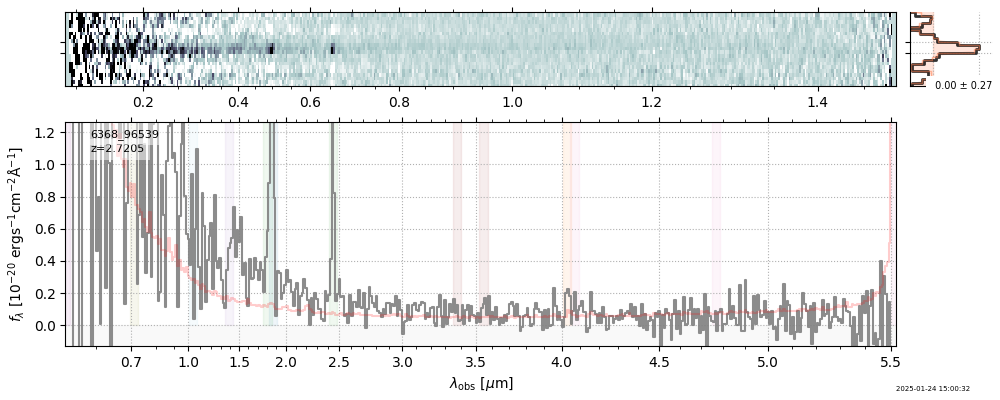

In [10]:
# Display the NIRSpec spectrum for the selected galaxy
if df_matched is not None and example_gal_id in df_matched.index:
    try:
        # Get spectrum file and construct URL
        spec_file = df_matched.loc[example_gal_id, 'spec_file']
        html_string = tab[tab['file'] == spec_file]['Spectrum_flam'][0]
        url = html_string.split('src="')[1].split('"')[0]
        
        print(f"Galaxy {example_gal_id} spectroscopic data:")
        print(f"  Spectroscopic redshift: z = {df_matched.loc[example_gal_id, 'spec_z']:.4f}")
        print(f"  Spectrum URL: {url}")
        
        # Download and display spectrum image
        response = requests.get(url)
        spec_img = Image.open(BytesIO(response.content))
        display(spec_img)
        
    except (KeyError, IndexError) as e:
        print(f"Error accessing spectrum: {e}")
else:
    print(f"Galaxy {example_gal_id} has no spectroscopic match in MSAExp catalog")

# Step 8: Display Complete Spectroscopic Information

Show all available metadata for the matched spectroscopic source, including links to cutouts, slit positions, and spectra.

In [11]:
# Display detailed spectroscopic information
if df_matched is not None and example_gal_id in df_matched.index:
    try:
        # Find matching spectroscopic entry
        spec_file = df_matched.loc[example_gal_id, 'spec_file']
        mask = tab['file'] == spec_file
        
        # Extract key columns
        spec_info = tab['root', 'file', 'z_best', 'Thumb', 'Slit_Thumb', 'Spectrum_flam'][mask].to_pandas()
        
        print(f"Complete spectroscopic information for galaxy {example_gal_id}:")
        print("="*70)
        display(Markdown(spec_info.to_markdown()))
        
        print("\n" + "="*70)
        print("Column descriptions:")
        print("  - 'Thumb': RGB cutout image")
        print("  - 'Slit_Thumb': NIRSpec slit position overlay")
        print("  - 'Spectrum_flam': 1D spectrum (f-lambda units)")
        
    except (KeyError, IndexError) as e:
        print(f"Error retrieving spectroscopic information: {e}")
else:
    print(f"No spectroscopic data available for galaxy {example_gal_id}")

Complete spectroscopic information for galaxy 70:


|    | root            | file                                             |   z_best | Thumb                                                                                                                                                                                                        | Slit_Thumb                                                                                                                                                                                                                                                 | Spectrum_flam                                                                                                                                |
|---:|:----------------|:-------------------------------------------------|---------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | capers-udsp5-v4 | capers-udsp5-v4_prism-clear_6368_96539.spec.fits |  2.72052 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.43843031%2C-5.21212867" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.43843031%2C-5.21212867&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw06368034001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/capers-udsp5-v4/capers-udsp5-v4_prism-clear_6368_96539.flam.png" height=200px> |


Column descriptions:
  - 'Thumb': RGB cutout image
  - 'Slit_Thumb': NIRSpec slit position overlay
  - 'Spectrum_flam': 1D spectrum (f-lambda units)


# Step 9: Cross-match X-ray Sources with JWST Photometry

Now that we've explored individual galaxies with spectroscopic data, we'll cross-match **Chandra X-ray detections** in the UDS field with the DJA JWST photometric catalog. This allows us to:

1. **Identify X-ray sources in JWST imaging** - Find the optical/NIR counterparts to X-ray detections
2. **Visualize X-ray AGN and star-forming galaxies** - Create JWST cutouts for each X-ray source
3. **Study the multi-wavelength properties** - Combine X-ray data with JWST photometry

The X-ray catalog is loaded from a VOTable file containing Chandra Source Catalog (CSC) detections. We'll perform spatial matching using sky coordinates to find JWST counterparts within a specified search radius.

In [12]:
from astropy.io import votable

xml_path = 'csccli-results.xml'

vot = votable.parse(xml_path)
table = vot.get_first_table()
column_names = [field.name for field in table.fields]

# Convert to astropy table first, then to pandas
astropy_table = table.to_table()
df_xray = astropy_table.to_pandas()

# Column names should already be correct, but you can verify/set them
df_xray.columns = column_names
df_xray.set_index('name', inplace=True)

  RA, Dec: 34.355825, -5.150039
Grizli Cluster Map: https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/uds/index.html?coords=34.355825,-5.150039&zoom=8
Cutout URL: https://grizli-cutout.herokuapp.com/thumb?coord=34.355825,-5.150039&all_filters=True&size=1.5&scl=3&asinh=True&filters=f090w-clear,f115w-clear,f150w-clear,f200w-clear,f277w-clear,f356w-clear,f444w-clear&rgb_scl=1.0,0.95,1.2&pl=2
  RA, Dec: 34.369593, -5.140923
Grizli Cluster Map: https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/uds/index.html?coords=34.369593,-5.140923&zoom=8
Cutout URL: https://grizli-cutout.herokuapp.com/thumb?coord=34.369593,-5.140923&all_filters=True&size=1.5&scl=3&asinh=True&filters=f090w-clear,f115w-clear,f150w-clear,f200w-clear,f277w-clear,f356w-clear,f444w-clear&rgb_scl=1.0,0.95,1.2&pl=2
  RA, Dec: 34.370717, -5.141007
Grizli Cluster Map: https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/uds/index.html?coords=34.370717,-5.141007&zoom=8
Cutout URL: https://grizli-cutout.herokuapp.com/thumb?coord

KeyboardInterrupt: 

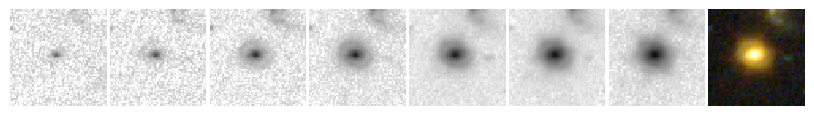

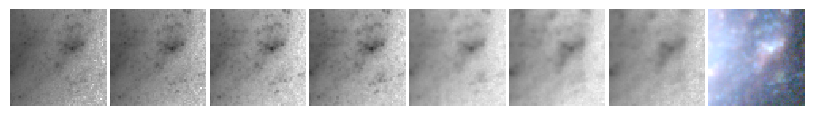

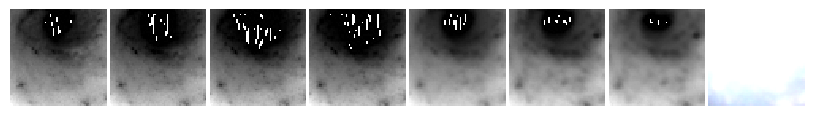

In [15]:
for index, galaxy in df_xray.T.items():

    print(f"  RA, Dec: {galaxy.ra:.6f}, {galaxy.dec:.6f}")
    # print(f"  Photometric redshift: {galaxy.z_phot:.3f}")
    # print(f"  Stellar mass: {np.log10(galaxy.mass):.2f} log(M☉)")

    # Create and display the image cutout
    id, fig, img = quick_cutout(galaxy)

    # break 

In [14]:
galaxy

separation           25.398929
ra                   34.355825
dec                  -5.150039
err_ellipse_r0         0.48351
err_ellipse_r1        0.437129
err_ellipse_ang      93.053833
significance               2.3
likelihood_class          TRUE
conf_flag                False
sat_src_flag             False
streak_src_flag          False
flux_aper_b                0.0
flux_aper_lolim_b          0.0
flux_aper_hilim_b          0.0
flux_aper_w                NaN
flux_aper_lolim_w          NaN
flux_aper_hilim_w          NaN
Name: 2CXO J021725.3-050900, dtype: object

# Step 10: Cross-match X-ray Sources with Spectroscopic Data

Now we'll cross-match the X-ray sources with the MSAExp spectroscopic catalog to identify which X-ray detections have spectroscopic redshift measurements. This is particularly valuable for identifying AGN and measuring their properties.

In [16]:
# Cross-match X-ray sources with MSAExp spectroscopic catalog

# Create coordinate objects for X-ray sources and spectroscopic sources
xray_coords = SkyCoord(ra=df_xray['ra'].values*u.degree, dec=df_xray['dec'].values*u.degree)
spec_coords_xray = SkyCoord(ra=tab['ra'], dec=tab['dec'])

# Find nearest spectroscopic neighbor for each X-ray source
idx_xray, d2d_xray, d3d_xray = xray_coords.match_to_catalog_sky(spec_coords_xray)

# Set matching radius for X-ray sources (typically larger due to X-ray positional uncertainty)
max_sep_xray = 1.0 * u.arcsec  # X-ray positions can have ~1" uncertainty
match_mask_xray = d2d_xray < max_sep_xray

num_xray_matches = match_mask_xray.sum()
print(f"Found {num_xray_matches} X-ray sources with spectroscopic matches within {max_sep_xray.value}\"")

# Create matched catalog for X-ray sources with spectroscopy
if num_xray_matches > 0:
    df_xray_spec_matched = df_xray[match_mask_xray].copy()
    matched_xray_spec_indices = idx_xray[match_mask_xray]
    
    # Add spectroscopic information to X-ray catalog
    df_xray_spec_matched['spec_sep_arcsec'] = d2d_xray[match_mask_xray].to(u.arcsec).value
    df_xray_spec_matched['spec_z'] = tab['z_best'][matched_xray_spec_indices]
    df_xray_spec_matched['spec_file'] = tab['file'][matched_xray_spec_indices]
    
    print(f"\nX-ray + Spectroscopy matched catalog created with {len(df_xray_spec_matched)} sources")
    print("\nMatched X-ray sources with spectroscopic data:")
    display(df_xray_spec_matched[['ra', 'dec', 'spec_z', 'spec_sep_arcsec']].head())
else:
    print("No X-ray sources found with spectroscopic matches")
    df_xray_spec_matched = None
    

Found 24 X-ray sources with spectroscopic matches within 1.0"

X-ray + Spectroscopy matched catalog created with 24 sources

Matched X-ray sources with spectroscopic data:


,ra,dec,spec_z,spec_sep_arcsec
name,,,,
2CXO J021720.9-050837,34.337363,-5.143697,4.555956,0.191043
2CXO J021725.2-050658,34.355416,-5.116273,2.762890,0.786882
2CXO J021721.1-050958,34.338261,-5.166194,3.950299,0.223500
2CXO J021730.6-051017,34.377661,-5.171573,1.665155,0.024872
2CXO J021729.6-051106,34.373611,-5.185006,2.207941,0.030903


In [17]:
# Display complete spectroscopic information for all matched X-ray sources

if df_xray_spec_matched is not None and len(df_xray_spec_matched) > 0:
    print(f"Spectroscopic data for {len(df_xray_spec_matched)} X-ray sources:")
    print("="*70)
    
    # Collect spectroscopic information for all matched X-ray sources
    all_spec_info = []
    
    for xray_name, xray_source in df_xray_spec_matched.iterrows():
        try:
            # Find matching spectroscopic entry
            spec_file = xray_source['spec_file']
            mask = tab['file'] == spec_file
            
            if mask.sum() > 0:
                # Extract key columns for this source
                spec_entry = tab['root', 'file', 'z_best', 'Thumb', 'Slit_Thumb', 'Spectrum_flam'][mask].to_pandas()
                
                # Add X-ray source name to the entry
                spec_entry.insert(0, 'X-ray_Name', xray_name)
                spec_entry.insert(1, 'X-ray_RA', xray_source['ra'])
                spec_entry.insert(2, 'X-ray_Dec', xray_source['dec'])
                spec_entry.insert(3, 'Match_Sep_arcsec', xray_source['spec_sep_arcsec'])
                
                all_spec_info.append(spec_entry)
        
        except (KeyError, IndexError) as e:
            print(f"Warning: Could not retrieve spectrum for {xray_name}: {e}")
    
    # Combine all spectroscopic information into a single dataframe
    if all_spec_info:
        combined_spec_info = pd.concat(all_spec_info, ignore_index=True)
        
        # Display the table in markdown format
        display(Markdown(combined_spec_info.to_markdown(index=False)))
        
        print("\n" + "="*70)
        print("Column descriptions:")
        print("  - 'X-ray_Name': Chandra Source Catalog identifier")
        print("  - 'X-ray_RA/Dec': X-ray source position")
        print("  - 'Match_Sep_arcsec': Separation between X-ray and spectroscopic position")
        print("  - 'z_best': Best spectroscopic redshift")
        print("  - 'Thumb': RGB cutout image (click to view)")
        print("  - 'Slit_Thumb': NIRSpec slit position overlay (click to view)")
        print("  - 'Spectrum_flam': 1D spectrum in f-lambda units (click to view)")
    else:
        print("No spectroscopic information could be retrieved")
        
else:
    print("No X-ray sources with spectroscopic matches found")

Spectroscopic data for 24 X-ray sources:


| X-ray_Name            |   X-ray_RA |   X-ray_Dec |   Match_Sep_arcsec | root              | file                                               |   z_best | Thumb                                                                                                                                                                                                        | Slit_Thumb                                                                                                                                                                                                                                                 | Spectrum_flam                                                                                                                                    |
|:----------------------|-----------:|------------:|-------------------:|:------------------|:---------------------------------------------------|---------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------|
| 2CXO J021720.9-050837 |    34.3374 |    -5.1437  |          0.191043  | gto-wide-uds13-v4 | gto-wide-uds13-v4_g395h-f290lp_1215_1472.spec.fits |  4.55596 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.33731548%2C-5.1436736" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.33731548%2C-5.1436736&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215013001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_g395h-f290lp_1215_1472.flam.png" height=200px> |
| 2CXO J021725.2-050658 |    34.3554 |    -5.11627 |          0.786882  | rubies-uds23-v4   | rubies-uds23-v4_g395m-f290lp_4233_163978.spec.fits |  2.76289 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.35556951%2C-5.11611681" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.35556951%2C-5.11611681&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233002003" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds23-v4/rubies-uds23-v4_g395m-f290lp_4233_163978.flam.png" height=200px>   |
| 2CXO J021721.1-050958 |    34.3383 |    -5.16619 |          0.2235    | gto-wide-uds13-v4 | gto-wide-uds13-v4_g395h-f290lp_1215_3330.spec.fits |  3.9503  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.33819936%2C-5.16620196" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.33819936%2C-5.16620196&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215013001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_g395h-f290lp_1215_3330.flam.png" height=200px> |
| 2CXO J021730.6-051017 |    34.3777 |    -5.17157 |          0.0248716 | gto-wide-uds13-v4 | gto-wide-uds13-v4_g235h-f170lp_1215_7330.spec.fits |  1.66516 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.37766625%2C-5.1715691" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.37766625%2C-5.1715691&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215013001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_g235h-f170lp_1215_7330.flam.png" height=200px> |
| 2CXO J021729.6-051106 |    34.3736 |    -5.18501 |          0.030903  | gto-wide-uds13-v4 | gto-wide-uds13-v4_g395h-f290lp_1215_4909.spec.fits |  2.20794 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.3736188%2C-5.18500345" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.3736188%2C-5.18500345&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215013001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_g395h-f290lp_1215_4909.flam.png" height=200px> |
| 2CXO J021717.4-051016 |    34.3225 |    -5.17137 |          0.0764166 | gto-wide-uds13-v4 | gto-wide-uds13-v4_g235h-f170lp_1215_3757.spec.fits |  3.94197 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.3225421%2C-5.17139126" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.3225421%2C-5.17139126&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215013001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds13-v4/gto-wide-uds13-v4_g235h-f170lp_1215_3757.flam.png" height=200px> |
| 2CXO J021721.1-050537 |    34.338  |    -5.09385 |          0.145187  | rubies-uds23-v4   | rubies-uds23-v4_g395m-f290lp_4233_179088.spec.fits |  1.77905 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.33800014%2C-5.09388345" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.33800014%2C-5.09388345&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233002003" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds23-v4/rubies-uds23-v4_g395m-f290lp_4233_179088.flam.png" height=200px>   |
| 2CXO J021713.1-051032 |    34.3047 |    -5.17576 |          0.0917379 | rubies-uds22-v4   | rubies-uds22-v4_prism-clear_4233_121002.spec.fits  |  2.66202 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.30467043%2C-5.17573948" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.30467043%2C-5.17573948&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233002002" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds22-v4/rubies-uds22-v4_prism-clear_4233_121002.flam.png" height=200px>    |
| 2CXO J021739.7-051018 |    34.4158 |    -5.17185 |          0.0848066 | gto-wide-uds11-v4 | gto-wide-uds11-v4_g395h-f290lp_1215_3483.spec.fits |  1.91679 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.41578815%2C-5.17187053" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.41578815%2C-5.17187053&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215011001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds11-v4/gto-wide-uds11-v4_g395h-f290lp_1215_3483.flam.png" height=200px> |
| 2CXO J021741.8-050811 |    34.4242 |    -5.13664 |          0.569662  | capers-udsp2-v4   | capers-udsp2-v4_prism-clear_6368_10997.spec.fits   |  5.14719 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.42429664%2C-5.13650669" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.42429664%2C-5.13650669&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw06368025001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/capers-udsp2-v4/capers-udsp2-v4_prism-clear_6368_10997.flam.png" height=200px>     |
| 2CXO J021743.5-050651 |    34.4315 |    -5.11431 |          0.18481   | capers-udsp2-v4   | capers-udsp2-v4_prism-clear_6368_6050.spec.fits    |  2.29222 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.43151763%2C-5.11435639" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.43151763%2C-5.11435639&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw06368025001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/capers-udsp2-v4/capers-udsp2-v4_prism-clear_6368_6050.flam.png" height=200px>      |
| 2CXO J021749.3-050624 |    34.4554 |    -5.10689 |          0.0608932 | rubies-uds32-v4   | rubies-uds32-v4_g395m-f290lp_4233_170368.spec.fits | -1       | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.45545477%2C-5.10687733" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.45545477%2C-5.10687733&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233003002" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds32-v4/rubies-uds32-v4_g395m-f290lp_4233_170368.flam.png" height=200px>   |
| 2CXO J021703.6-051204 |    34.2652 |    -5.20128 |          0.177146  | rubies-uds3-v4    | rubies-uds3-v4_g395m-f290lp_4233_64018.spec.fits   |  2.08028 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2652411%2C-5.2012426" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2652411%2C-5.2012426&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233001003" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds3-v4/rubies-uds3-v4_g395m-f290lp_4233_64018.flam.png" height=200px>      |
| 2CXO J021734.5-051448 |    34.394  |    -5.24686 |          0.341285  | rubies-uds41-v4   | rubies-uds41-v4_g395m-f290lp_4233_44857.spec.fits  |  2.29604 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.39405062%2C-5.2468808" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.39405062%2C-5.2468808&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233004001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds41-v4/rubies-uds41-v4_g395m-f290lp_4233_44857.flam.png" height=200px>    |
| 2CXO J021745.0-051335 |    34.4377 |    -5.22655 |          0.322648  | gto-wide-uds12-v4 | gto-wide-uds12-v4_prism-clear_1215_5571.spec.fits  |  3.6393  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.43776348%2C-5.22658284" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.43776348%2C-5.22658284&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215012001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds12-v4/gto-wide-uds12-v4_prism-clear_1215_5571.flam.png" height=200px>  |
| 2CXO J021710.8-051519 |    34.2953 |    -5.25533 |          0.0361459 | gto-wide-uds14-v4 | gto-wide-uds14-v4_prism-clear_1215_1283.spec.fits  |  1.95582 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.29531423%2C-5.25534044" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.29531423%2C-5.25534044&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215014001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds14-v4/gto-wide-uds14-v4_prism-clear_1215_1283.flam.png" height=200px>  |
| 2CXO J021753.6-051250 |    34.4735 |    -5.21402 |          0.16837   | capers-udsp5-v4   | capers-udsp5-v4_prism-clear_6368_27778.spec.fits   | -1       | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.47353021%2C-5.21406772" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.47353021%2C-5.21406772&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw06368034001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/capers-udsp5-v4/capers-udsp5-v4_prism-clear_6368_27778.flam.png" height=200px>     |
| 2CXO J021704.9-051500 |    34.2704 |    -5.25015 |          0.150881  | rubies-uds1-v4    | rubies-uds1-v4_g395m-f290lp_4233_38011.spec.fits   | -1       | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2704428%2C-5.2501091" height=200px>   | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.2704428%2C-5.2501091&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233001001" height=200px>   | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds1-v4/rubies-uds1-v4_g395m-f290lp_4233_38011.flam.png" height=200px>      |
| 2CXO J021741.6-051616 |    34.4234 |    -5.27114 |          0.238102  | gto-wide-uds12-v4 | gto-wide-uds12-v4_prism-clear_1215_4250.spec.fits  |  1.91162 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.42342421%2C-5.27118234" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.42342421%2C-5.27118234&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215012001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds12-v4/gto-wide-uds12-v4_prism-clear_1215_4250.flam.png" height=200px>  |
| 2CXO J021709.4-051611 |    34.2894 |    -5.26984 |          0.133389  | excels-uds04-v4   | excels-uds04-v4_g395m-f290lp_3543_34495.spec.fits  |  3.79714 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.28946337%2C-5.26981041" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.28946337%2C-5.26981041&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw03543004001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/excels-uds04-v4/excels-uds04-v4_g395m-f290lp_3543_34495.flam.png" height=200px>    |
| 2CXO J021802.9-051121 |    34.5124 |    -5.18927 |          0.132906  | gto-wide-uds10-v4 | gto-wide-uds10-v4_g235h-f170lp_1215_3470.spec.fits |  2.30262 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.51237978%2C-5.1892346" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.51237978%2C-5.1892346&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215010001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds10-v4/gto-wide-uds10-v4_g235h-f170lp_1215_3470.flam.png" height=200px> |
| 2CXO J021752.6-051535 |    34.4694 |    -5.25995 |          0.107038  | gto-wide-uds12-v4 | gto-wide-uds12-v4_g395h-f290lp_1215_7269.spec.fits |  0.94226 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.4694284%2C-5.25995223" height=200px>  | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.4694284%2C-5.25995223&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215012001" height=200px>  | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds12-v4/gto-wide-uds12-v4_g395h-f290lp_1215_7269.flam.png" height=200px> |
| 2CXO J021704.0-051741 |    34.2669 |    -5.2948  |          0.2257    | rubies-uds1-v4    | rubies-uds1-v4_g395m-f290lp_4233_12220.spec.fits   |  2.58501 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.266956%2C-5.294818" height=200px>     | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.266956%2C-5.294818&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw04233001001" height=200px>     | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-uds1-v4/rubies-uds1-v4_g395m-f290lp_4233_12220.flam.png" height=200px>      |
| 2CXO J021813.0-051158 |    34.5543 |    -5.19946 |          0.14439   | gto-wide-uds10-v4 | gto-wide-uds10-v4_prism-clear_1215_3995.spec.fits  |  3.30651 | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=2.0&asinh=True&filters=f115w-clear%2Cf277w-clear%2Cf444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.55429592%2C-5.19947981" height=200px> | <img src="https://grizli-cutout.herokuapp.com/thumb?size=1.5&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord=34.55429592%2C-5.19947981&nirspec=True&dpi_scale=6&nrs_lw=0.5&nrs_alpha=0.8&metafile=jw01215010001" height=200px> | <img src="https://s3.amazonaws.com/msaexp-nirspec/extractions/gto-wide-uds10-v4/gto-wide-uds10-v4_prism-clear_1215_3995.flam.png" height=200px>  |


Column descriptions:
  - 'X-ray_Name': Chandra Source Catalog identifier
  - 'X-ray_RA/Dec': X-ray source position
  - 'Match_Sep_arcsec': Separation between X-ray and spectroscopic position
  - 'z_best': Best spectroscopic redshift
  - 'Thumb': RGB cutout image (click to view)
  - 'Slit_Thumb': NIRSpec slit position overlay (click to view)
  - 'Spectrum_flam': 1D spectrum in f-lambda units (click to view)


# Interpreting X-ray + Spectroscopic Matches

The table above shows X-ray sources that have spectroscopic observations. Key points:

- **X-ray AGN Identification**: Most X-ray sources in the UDS field are Active Galactic Nuclei (AGN)
- **Spectroscopic Confirmation**: The spectroscopic redshifts confirm the distances to these X-ray sources
- **Multi-wavelength Analysis**: You can click the image links to view:
  - **Thumb**: JWST multi-band cutout showing the galaxy hosting the X-ray source
  - **Slit_Thumb**: NIRSpec slit position overlaid on the sky image
  - **Spectrum_flam**: 1D extracted spectrum with emission/absorption lines

This demonstrates the power of combining X-ray, JWST imaging, and NIRSpec spectroscopy for AGN studies!

# Summary and Next Steps

## What We've Demonstrated

This notebook showcased the key tools available through the DAWN JWST Archive (DJA) for extragalactic field analysis:

✅ **DJA Photometric Catalogs** - Accessed multi-band JWST photometry from Grizli reductions  
✅ **Spectroscopic Cross-matching** - Linked photometric sources to MSAExp NIRSpec observations  
✅ **Image Cutout Server** - Created on-demand JWST cutouts via the Grizli web service  
✅ **EAzY SED Fits** - Visualized photometric redshift template fitting results  
✅ **Spectrum Display** - Accessed and displayed 1D NIRSpec spectra from AWS

## Exploring More Galaxies

To analyze different galaxies, change the `example_gal_id` variable and re-run the analysis cells:

```python
# Try these examples:
example_gal_id = 110      # Current example
example_gal_id = 1085391  # Try another source
example_gal_id = 1124656  # Or this one
```

## Finding Interesting Targets

Filter the matched catalog to find specific types of objects:

```python
# High-redshift galaxies (z > 3)
high_z = df_matched[df_matched['spec_z'] > 3]

# Low-redshift sample (z < 1)
low_z = df_matched[df_matched['spec_z'] < 1]

# Browse the full matched catalog
display(df_matched[['ra', 'dec', 'spec_z']].head(20))
```

## Available Fields

The DJA archive contains data for multiple JWST fields. Check available mosaics at:
- **Main catalog**: https://s3.amazonaws.com/grizli-v2/JwstMosaics/
- **Interactive map**: https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/

## Data Credits

- **DJA/Grizli**: JWST data reduction and photometric catalogs (G. Brammer et al.)
- **MSAExp**: Public NIRSpec spectroscopic database (hosted on AWS)
- **EAzY**: Photometric redshift fitting code (Brammer et al. 2008)
- **PRIMER**: JWST Public Release Imaging for Extragalactic Research survey

## Troubleshooting

- **Network issues**: Cutout server and AWS data require internet access
- **Slow loading**: Large cutouts take time; reduce `size` parameter if needed
- **Missing spectra**: Not all photometric sources have spectroscopic observations
- **EAzY files**: Download may be slow; files are cached locally after first download